In [1]:
from nn import NeuralNetwork
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

## Load in data, make training (80%) and validation (20%) sets

In [2]:
data = load_digits()["data"]
n = data.shape[0]
train_rows = int(0.8*n) # 80% train, 20% validation

In [3]:
np.random.shuffle(data)
X_train, X_val = data[0:train_rows, :], data[train_rows:n, :]

## Train autoencoder, searching over grid of hyperparameters

In [4]:
epochs = [10, 20, 30, 40, 50]
lrs = [1, 0.1, 0.01, 0.001]
batch_sizes = [10, 20, 30, 40, 50]
activations = ["relu", "sigmoid"]
val_loss = np.zeros((len(epochs), len(lrs), len(batch_sizes), len(activations))) # validation loss as a function of the hyperparameters

In [5]:
for e, epoch in enumerate(epochs):
    for l, lr in enumerate(lrs):
        for b, batch_size in enumerate(batch_sizes):
            for a, activation in enumerate(activations):
                
                net = NeuralNetwork([{'input_dim': 64, 'output_dim': 16, 'activation': activation},
                                     {'input_dim': 16, 'output_dim': 64, 'activation': activation}],
                                    lr, 42, batch_size, epoch, "mse")
                
                # this is a reconstruction task, so the data and the target are the same 
                net.fit(X_train, X_train, X_val, X_val)
                # get validation loss
                val_loss[e, l, b, a] = net._mean_squared_error(X_val, net.predict(X_val))

/Users/grantgoldman/Library/Python/3.7/lib/python/site-packages/nn/nn.py:361: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(Z))


In [6]:
# get one set of best hyperparameters (potentially could be more than one)
min_val_loss_idxs = np.where(val_loss == np.min(val_loss))
one_min_idx = [x[0] for x in min_val_loss_idxs]
epoch, lr, batch_size, activation = epochs[one_min_idx[0]], lrs[one_min_idx[1]], batch_sizes[one_min_idx[2]], activations[one_min_idx[3]]
print(f"Selected hyperparameters: epochs: {epoch}, learning rate: {lr}, batch_size: {batch_size}, activation: {activation}")

Selected hyperparameters: epochs: 50, learning rate: 0.01, batch_size: 10, activation: sigmoid


## Now, run the model with the best performing hyperparameters

In [7]:
net = NeuralNetwork([{'input_dim': 64, 'output_dim': 16, 'activation': activation},
                     {'input_dim': 16, 'output_dim': 64, 'activation': activation}],
                    lr, 42, batch_size, epoch, "mse")
train_loss, val_loss = net.fit(X_train, X_train, X_val, X_val)

ValueError: x and y must have same first dimension, but have shapes (49,) and (5,)

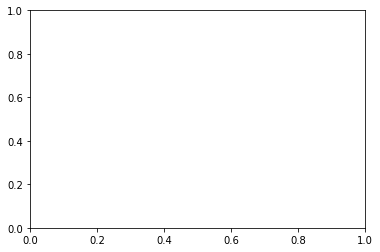

In [12]:
epochs = [x for x in range(len(epochs))]
plt.plot(train_loss, epochs)

In [13]:
epochs

[0, 1, 2, 3, 4]